<a href="https://colab.research.google.com/github/matteoamagliani/NLP/blob/main/L07_1_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L07 – Topic Modelling with BERTopic (Part I)

In this lab, we will build a **complete topic modelling pipeline** using a collection of *real scientific abstracts*.
Unlike supervised text classification, topic modelling is an **unsupervised** technique: the model discovers underlying themes in the corpus **without predefined labels**.

Scientific abstracts are particularly well suited for this task. They are concise, domain-specific, and often centred around a single main idea, making them ideal for learning how to identify coherent topics in real-world text.

The goal of this session is to:

1. Load and prepare a real-world text dataset for unsupervised analysis.
2. Understand the role of **contextual embeddings** as the foundation of modern topic modelling.
3. Apply **dimensionality reduction** to make clustering feasible and meaningful.
4. Use **HDBSCAN** to discover dense clusters and identify outliers.
5. Configure **vectorisers** for topic representation.
6. Generate interpretable topics using **c-TF-IDF**.
7. Understand the effect of key **fine-tuning parameters** in BERTopic.
8. Build, train, and inspect a full BERTopic model.

Topic modelling is frequently used in exploratory data analysis, literature review automation, scientific trend discovery, and large-scale document organisation.
By the end of this session, you will understand how BERTopic combines modern NLP components—**embeddings, dimensionality reduction, clustering, and c-TF-IDF**—to reveal latent structure in textual data.

## What is BERTopic?

BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

You can find a brief overview of BERTopic in the following [link](https://maartengr.github.io/BERTopic/algorithm/algorithm.html).

## 1. Imports and loading dataset


In [ ]:
!pip install umap-learn
!pip install hdbscan
!pip install sentence-transformers
!pip install bertopic
!pip install nltk
!pip install datamapplot
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.5/168.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 24.8 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5969 sha256=f583ff91ac895f246e3130e3127980b6fd0bf62db8a398da2fc5bec90da9678c
  Stored in directory: /root/.cache/pip/wheels/86/02/24/506ac193949f48c8bec599b613d722bd64a83063a190b3bff7
Successfully built Pyqtree
  Attempting uninstall: dask
    Found exis

This block imports the main components used in the BERTopic workflow:

* `UMAP` and `PCA` provide dimensionality reduction so that clustering becomes feasible.
* `HDBSCAN` is the clustering algorithm that groups documents into topics.
* `SentenceTransformer` generates the document embeddings used as input to the model.
* `CountVectorizer` builds the term-frequency matrix needed for topic representation.
* `pandas` handles loading and working with the dataset.
* `datamapplot` allows simple visualisations of document embeddings.
* `BERTopic` integrates all these steps into a complete topic modelling pipeline.
* `KeyBERTInspired` and `ClassTfidfTransformer` help refine how topics are represented and labelled.

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import datamapplot

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## 2. Loading dataset

In [ ]:
df_abstracts = pd.read_csv('/content/abstracts.csv')

For computational efficiency, we restrict the analysis to the first 1,000 abstracts. This subset is sufficient to illustrate the complete BERTopic workflow while keeping execution time manageable.

In [ ]:
df_abstracts = df_abstracts[:1000]

In [ ]:
df_abstracts

,scopus_id,title,abstract
0,84962233486,Tangible user interfaces to digitalize real en...,There are essential activities focused on lear...
1,84921758489,Petri nets-based model for the analysis of NOR...,Network rOle-based Routing Intelligent Algorit...
2,84948688411,ViDRILO: The visual and depth robot indoor loc...,In this article we describe a semantic localiz...
3,84954056170,A simulation tool for monitoring elderly who s...,This paper addresses the challenging problem o...
4,84923495518,Gaussian modeling of the P-wave morphology tim...,This paper introduces a new algorithm to quant...
...,...,...,...
995,85098859266,Smartwalk ban: Using body area networks to enc...,Due to the demographic ageing of the world’s p...
996,85087050645,Virtual Reality Simulation of a Quadrotor to M...,Unmanned aerial vehicles (UAVs) represent an a...
997,84949533854,Statistical multi-model climate projections of...,"In recent years, the impact of climate change ..."
998,84941911172,Detection of Multivariate Cyclostationarity,This paper derives an asymptotic generalized l...


## 3. Topic Modeling Step by step with BERTopic

BERTopic can be viewed as a sequence of steps to create its topic representations. There are five steps to this process:

![BERTopicPipeline](https://maartengr.github.io/BERTopic/algorithm/default.svg)

BERTopic is quite modular and can maintain its quality of topic generation throughout a variety of sub-models. In other words, BERTopic essentially allows you to build your own topic model:

![BERTopicModularity](https://maartengr.github.io/BERTopic/algorithm/modularity.svg)


### 3.1 Embeddings (transformation)

We start by converting our documents to numerical representations. Although there are many methods for doing so the default in BERTopic is sentence-transformers.

**Word embeddings** are numerical representations of text where each token (word or subword) is mapped to a vector in a continuous, high-dimensional vector space. In this space, words with similar meanings are represented by vectors that are close to each other, capturing semantic and syntactic relationships within the text.

Word embeddings can be generated using various techniques, with some of the most common methods being Word2Vec and GloVe.

* **Word2Vec** learns embeddings by capturing probabilistic relationships between words in a corpus. It builds a linguistic model based on the context of words, allowing it to infer a semantic representation (embedding) for each token.
* **GloVe** (Global Vectors for Word Representation) is an unsupervised learning method that constructs embeddings by analyzing the global co-occurrence statistics of words within a corpus. It leverages the co-occurrence matrix to represent words as vectors in a space that preserves contextual relationships.

In both methods, embeddings are automatically generated based on the contextual information provided by words in a given corpus. Additionally, pre-computed word embeddings trained on large-scale corpora—such thus that you can find in [sentence transformer](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)—are publicly available and widely used for downstream tasks, offering rich semantic representations without the need for retraining.

In [ ]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = embedding_model.encode(df_abstracts['abstract'], show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

### 3.2 Dimensionality Reduction

Dimensionality reduction projects high-dimensional embeddings into a lower-dimensional space. This makes the data easier to cluster and, in some cases, easier to visualise.

Two common methods are:

**PCA (Principal Component Analysis)**
A linear technique that finds new axes (principal components) capturing most of the variation in the data. It simplifies the representation while keeping as much global structure as possible.

**UMAP (Uniform Manifold Approximation and Projection)**
A non-linear method that preserves local neighbourhoods more effectively than PCA. It is often used before clustering because it creates compact, well-separated regions in low-dimensional space. UMAP is also widely used for visualisation.

UMAP is the default dimensionality reduction method in BERTopic because it tends to produce clearer clusters for text embeddings.

This UMAP model reduces the embedding dimensionality before clustering.
The parameters used here control how the projection is built:

* `n_neighbors=15`: how much local structure to preserve.
* `n_components=10`: size of the reduced space.
* `metric='cosine'`: distance measure for comparing embeddings.
* `random_state=42`: ensures reproducibility.

In [ ]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42, low_memory=False)

### 3.3 Clustering

After having reduced our embeddings, we can start clustering our data. The BERTopic pipeline usually use a version of DBSCAN called HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise). The main differences between both of them are:

*   DBSCAN identifies dense regions separated by low-density areas, while HDBSCAN merges smaller clusters recursively, allowing varying densities and subclusters.
*   DBSCAN is faster for large datasets due to its simpler approach, while HDBSCAN slower because of recursion, but more robust and precise
* DBSCAN Does not provide a hierarchical view of clusters, while HDBSCAN generates a dendrogram to visualize hierarchical cluster structures.

But you can choose any cluster model that fits your use case, for exameple k-means.

This HDBSCAN model clusters the reduced embeddings and identifies dense groups of documents:

* `metric='euclidean'`: distance used in the reduced space.
* `cluster_selection_method='eom'`: selects clusters based on cluster stability.
* `prediction_data=True`: enables later inspection and visualisation of cluster membership.

In [ ]:
# Step 3 - Cluster reduced embeddings
cluster_model = HDBSCAN(metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### 3.4 Vectorisers

BERTopic constructs a bag-of-words representation for more effective topic modeling. In this process, we use the CountVectorizer to generate a term frequency (TF) representation, where each cluster is treated as a distinct topic. Each topic is then ranked based on its relevance to the vocabulary of the corpus.

In [ ]:
# Step 4 - bag-of-words representation
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1,2))

### 3.5 Topic representation

In BERTopic, the traditional TF-IDF is adjusted to operate at the cluster or topic level rather than the document level. This modified version, called c-TF-IDF, highlights the distinguishing features of documents within a cluster compared to documents in other clusters:

![c-TF-IDF](https://maartengr.github.io/BERTopic/algorithm/c-TF-IDF.svg)

Each cluster is converted to a single document instead of a set of documents. Then, we extract the frequency of word x in class c, where c refers to the cluster we created before. This results in our class-based tf representation. This representation is L1-normalized to account for the differences in topic sizes.

Then, we take the logarithm of one plus the average number of words per class A divided by the frequency of word x across all classes. We add plus one within the logarithm to force values to be positive. This results in our class-based idf representation. Like with the classic TF-IDF, we then multiply tf with idf to get the importance score per word in each class. In other words, the classical TF-IDF procedure is not used here but a modified version of the algorithm that allows for a much better representation.

In [ ]:
# Step 5 - Create topic representation (extract topic words)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

### 3.6 Fine Tunning

One of the key features of **BERTopic** is its **Bag-of-Words** representation, weighted with **c-TF-IDF**, which quickly generates relevant keywords for each topic. This approach allows topics to be updated easily after model training, without requiring retraining. While the default method provides good topic representations, BERTopic also offers optional models for further fine-tuning topic representations like KeyBERT.

[KeyBERT](https://github.com/MaartenGr/KeyBERT) is a minimal and easy-to-use keyword extraction technique that leverages BERT embeddings to create keywords and keyphrases that are most similar to a document.


In [ ]:
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
representation_model = KeyBERTInspired()

### 3.7 Model setup and training

This step brings together the six components explained earlier into a single BERTopic model.
In addition, a few extra configuration options are included:

* `n_gram_range=(1, 2)`: allows topics to include both single words and bigrams.
* `verbose=True`: prints progress information during training.
* `language='english'`: specifies the language used by the vectorizer.
* `min_topic_size`: (optional) sets the minimum number of documents required for a topic to be formed.

In [ ]:
# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                     # Step 2 - Reduce dimensionality
  hdbscan_model=cluster_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  calculate_probabilities = True,
  #min_topic_size = 50,
  n_gram_range=(1, 2),
  verbose = True,
  language='english'
)

This command fits the BERTopic model to the abstracts and returns the assigned topic for each document (`topics`) and the corresponding topic probabilities (`probs`).

In [ ]:
# Trainning process
topics, probs = topic_model.fit_transform(df_abstracts['abstract'])

2025-12-01 12:45:49,048 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-12-01 12:45:51,605 - BERTopic - Embedding - Completed ✓
2025-12-01 12:45:51,606 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-01 12:46:02,466 - BERTopic - Dimensionality - Completed ✓
2025-12-01 12:46:02,467 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-01 12:46:02,635 - BERTopic - Cluster - Completed ✓
2025-12-01 12:46:02,640 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-01 12:46:05,839 - BERTopic - Representation - Completed ✓


Displays a table summarising all discovered topics.

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,223,-1_sensor_activities_software_tools,"[sensor, activities, software, tools, cognitiv...",[Context Lack of coordination may create signi...
1,0,38,0_software modelling_modelling_data modeling_m...,"[software modelling, modelling, data modeling,...",[Context: Global Software Development (GSD) al...
2,1,37,1_tracking performance_design_performance prop...,"[tracking performance, design, performance pro...",[In this paper we address the trajectory track...
3,2,29,2_ports_computing_performance computing_network,"[ports, computing, performance computing, netw...",[The interconnection network architecture is c...
4,3,26,3_systems maxterm_systems_dynamical systems_pa...,"[systems maxterm, systems, dynamical systems, ...",[For parallel dynamical systems over undirecte...
5,4,24,4_coding performance_coding efficiency_coding ...,"[coding performance, coding efficiency, coding...",[High efficiency video coding (HEVC) was devel...
6,5,23,5_prevents industry_analysis surveillance_mult...,"[prevents industry, analysis surveillance, mul...",[CORTEX is a cognitive robotics architecture i...
7,6,21,6_functional scales_monitoring_movement based_...,"[functional scales, monitoring, movement based...",[The aim of this study is to assess the impact...
8,7,21,7_point projection_aspect ratio_diagram_cam,"[point projection, aspect ratio, diagram, cam,...","[In finite element analysis, among the possibl..."
9,8,20,8_visilab viewer_descriptors_standardization m...,"[visilab viewer, descriptors, standardization ...",[Whole slide imaging (WSI) scanners and automa...


## 4. Visualization

### 4.1 Intertopic Distance Map
This plot shows the spatial arrangement of all topics in a two-dimensional space, allowing you to see how clusters relate to each other and how well they are separated.

In [ ]:
topic_model.visualize_topics()

### 4.2 Hierarchical Topic Visualization

Displays a dendrogram showing how topics group together hierarchically, highlighting relationships and possible topic merges.


In [ ]:
topic_model.visualize_hierarchy()

### 4.3 Topic Similarity Heatmap

Shows a heatmap of pairwise topic similarities, helping identify closely related topics and potential candidates for merging.

In [ ]:
topic_model.visualize_heatmap()

### 4.4 Document Map (Using Original Embeddings)

Creates a two-dimensional map showing how individual documents are positioned relative to one another based on their original embeddings. This helps inspect cluster shapes and the distribution of abstracts in the embedding space.

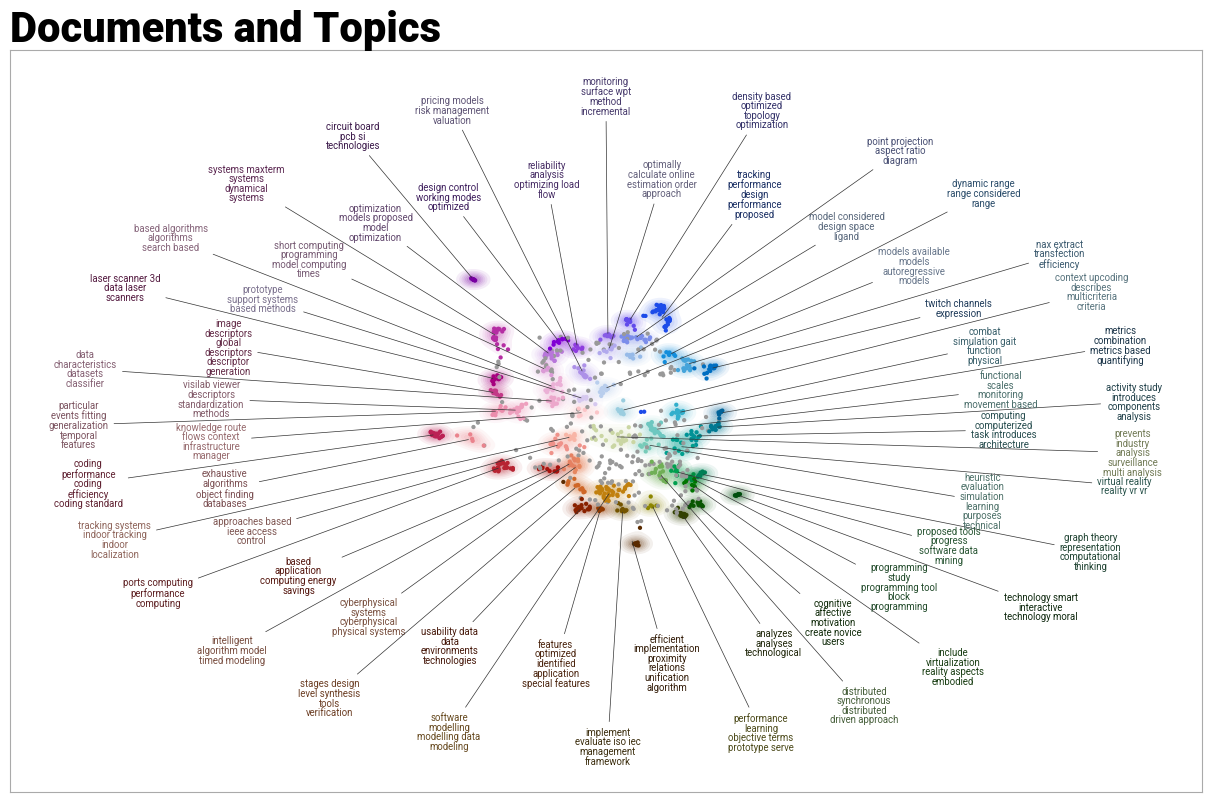

In [ ]:
# with the original embeddings
topic_model.visualize_document_datamap(df_abstracts['abstract'], embeddings=embeddings);

## END OF PART I
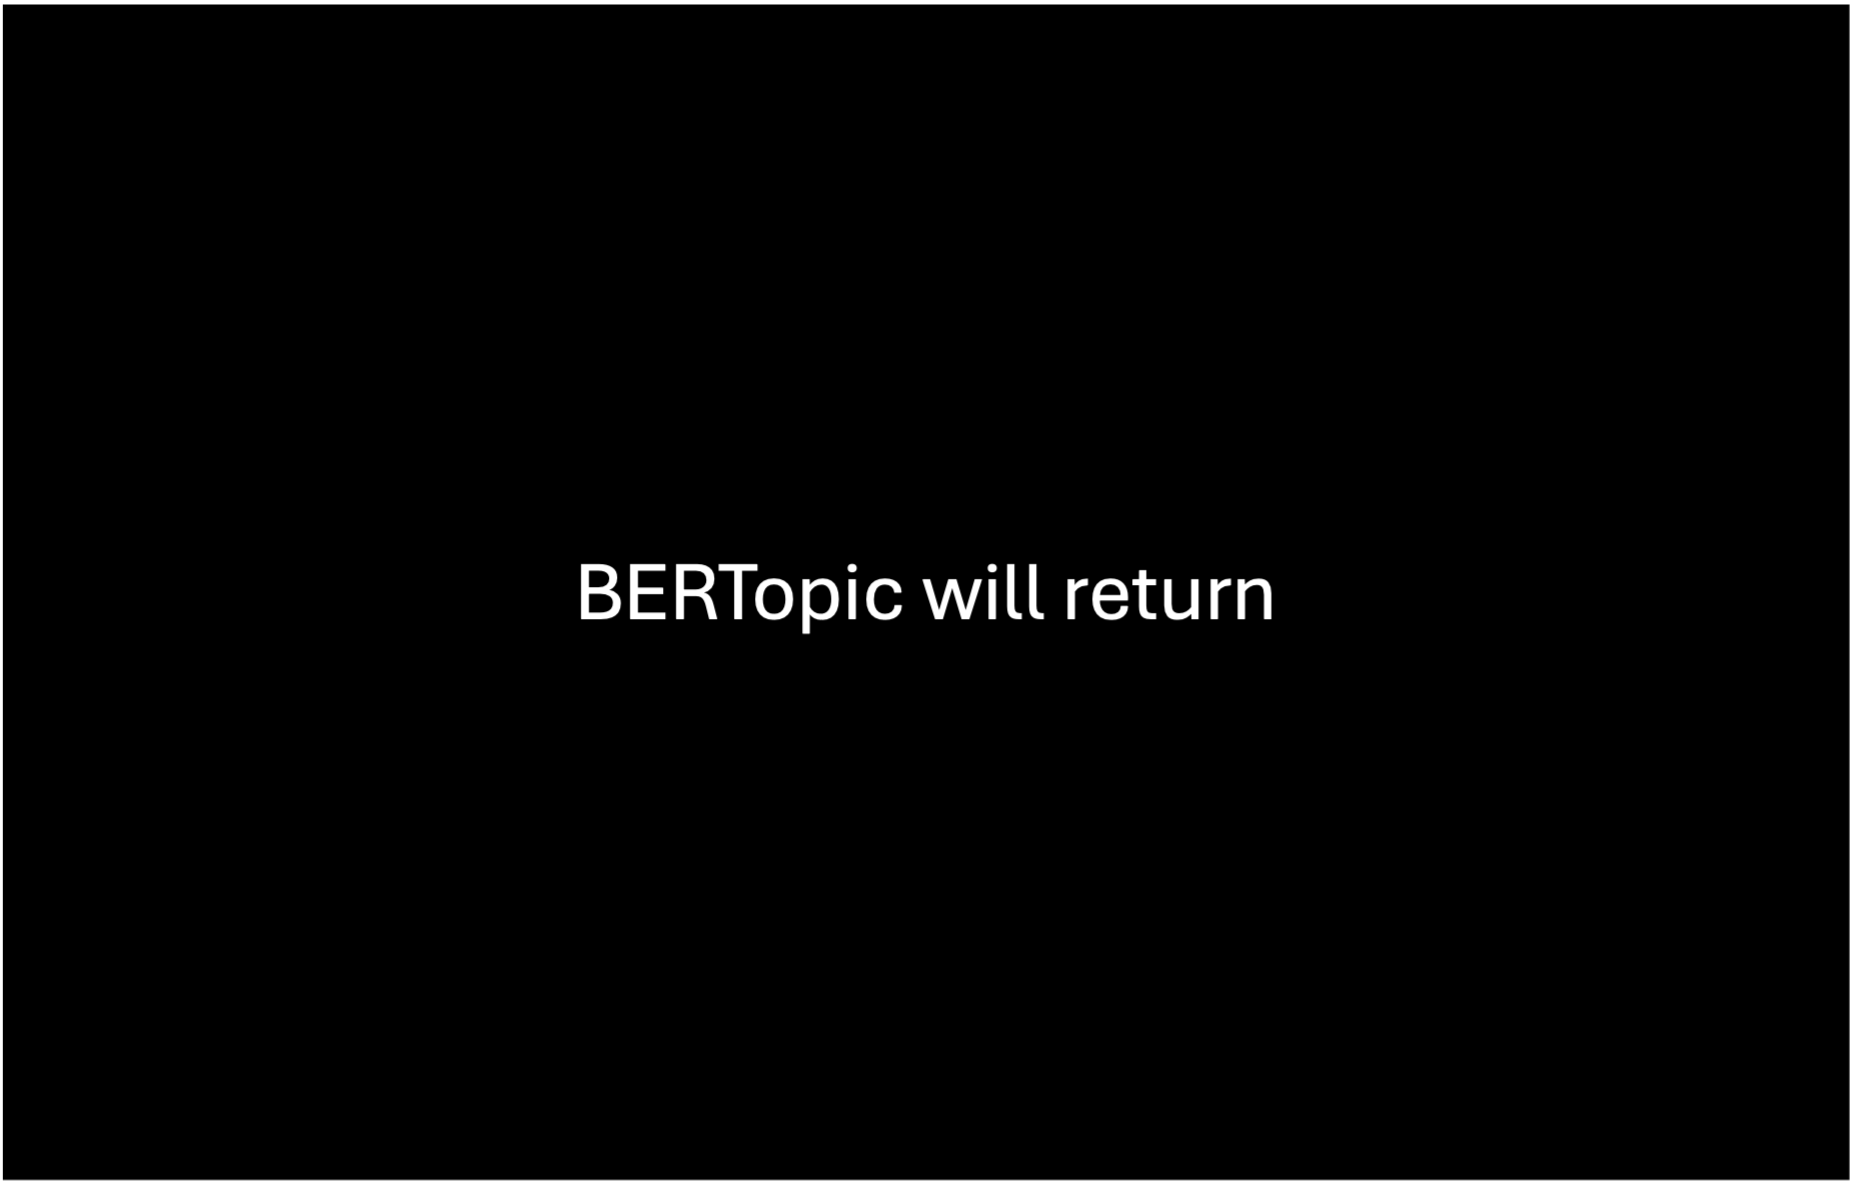

## Practice – Topic Modelling with BERTopic (Scientific Abstracts)

In this assignment, you will reproduce the complete **topic modelling workflow** presented in the notebook *L07 – Topic Modelling (Part I)*, but using the **remaining half** of the abstract dataset (the 1000 abstracts that were not used during the lab session).

This will allow you to explore how BERTopic behaves on a different subset of the same corpus and compare topic structure, coherence, and clustering quality.

You may follow the structure shown in the notebook, and if necessary, you are allowed to modify selected parameters of the BERTopic pipeline (embeddings, UMAP settings, clustering, or vectorisation) to obtain more meaningful topics.

---

# Task Objective

Your goal is to implement a full BERTopic modelling pipeline that includes:

1. Loading the remaining abstracts from the dataset.
2. Building the BERTopic components:

   * Embedding model
   * Dimensionality reduction
   * HDBSCAN clustering
   * Bag-of-words vectoriser
   * c-TF-IDF representation
3. Training a **complete BERTopic model**.
4. Inspecting the discovered topics:

   * the topic overview table
   * top words of selected topics
   * representative documents
5. Visualising the results using:

   * intertopic distance map
   * hierarchical topic tree
   * topic similarity heatmap
   * (optional) document datamap

You may adjust parameters such as `n_neighbors`, `min_cluster_size`, `n_gram_range` or the embedding model if doing so improves topic quality.

---

# Reflection Questions

1. **Which topics appear most coherent across your subset?**
   Briefly explain what makes them coherent (e.g., consistent vocabulary, clear scientific theme).

2. **How does the topic structure of your subset compare with what we observed in class?**
   Mention similarities or differences in themes or cluster clarity.

3. **If you wanted to improve the overall quality of the topics, what parameter or component would you adjust first?**
   (e.g., embedding model, n-grams, UMAP dimensionality, clustering settings, topic merging).